# Negative sampling

You may have noticed that word2vec is really slow to train. Especially with big (> 50 000) vocabularies. Negative sampling is the solution.

The task is to implement word2vec with negative sampling. In more detail: you should implement two ways of negative sampling.

## Vanilla negative sampling

This is what was discussed in Stanford lecture. The main idea is in the formula:

$$ L = \log\sigma(u^T_o u_c) + \sum^k_{i=1} \mathbb{E}_{j \sim P(w)}[\log\sigma(-u^T_j, u_c)]$$

Where $\sigma$ - sigmoid function, $u_c$ - central word vector, $u_o$ - context (outside of the window) word vector, $u_j$ - vector or word with index $j$.

The first term calculates the similarity between positive examples (word from one window)

The second term is responsible for negative samples. $k$ is a hyperparameter - the number of negatives to sample.
$\mathbb{E}_{j \sim P(w)}$
means that $j$ is distributed accordingly to unigram distribution, but it is better to use $P^{3/4}(w)$ (empirical results) and you can experiment with some other approaches (for example, try to use uniform distribution).

Thus, it is only required to calculate the similarity between positive samples and some other negatives. Not across all the vocabulary.

Useful links:
1. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
1. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

## Batch-transpose trick for negative sampling

But we can do better. Maybe we don't need to compute vectors for negative samples at all, because we already have a batch of training data and (hopefully) examples in the batch are highly decorrelated.

Let's assume we work with Skip-gram model.

Let $S$ be a batch of _L2-normalized_ word vectors `(batch_size, 2*window_size + 1, word_vector_dim)`.

```python
x = 0.0
for batch_idx in range(batch):
    w = S[batch_idx, :, :]
    x += np.sum(w.T @ w - 1.)

y = 0.0
for window_idx in range(window):
    b = S[:, window_idx, :]
    y += np.sum(b.T @ b)

loss = -x + y```

Think about this loss and compare it to vanilla negative sampling.

Implement word2vec with batch-transpose trick. Modify the formula, if needed.

If you are interested: [more info](https://www.tensorflow.org/extras/candidate_sampling.pdf) on other methods of candidate sampling.

**Results of this task** are the very same as in task 3, **plus**:
 * implement two models (one with vanilla negative sampling and the other with batch-transpose trick)
 * compare all of the models from tasks 3-5. In terms of time and number of iterations until convergence and the quality of the resulting vectors.
 * answer the questions

### Questions:
1. Explain the batch-transpose trick formula in your own words. How would you name x, y, w and b?
1. Should it be modified to serve as a word2vec loss? If yes, how?
1. Is it possible to do the same trick with CBOW model? If yes, how?
1. Does it matter how the batch is made in the case of batch-transpose trick? In the case of vanilla negative sampling?




## Answers:
  1. _
  1. _
  1. _
  1. _

In [1]:
from pathlib import Path
from collections import Counter
from itertools import islice, product, chain
from argparse import Namespace

from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorboardX import SummaryWriter
from annoy import AnnoyIndex

from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP
from adjustText import adjust_text

In [2]:
DATA_PATH = Path('../data')
MODELS_PATH = Path('../models')

In [3]:
class SkipGramBatcher():
    def __init__(self, text):
        self.text = text
    
    @classmethod
    def from_file(cls, file_path):
        with open(file_path) as f:
            text = f.read()
        
        return cls(text)
    
    def _tokenize(self):
        self.tokens = self.text.split()
    
    def _count_tokens(self):
        self.token_counts = Counter(self.tokens)
    
    def _build_vocab(self, cutoff):
        self.token_counts = dict(filter(lambda x: x[1] >= cutoff, self.token_counts.items()))
        self.token_to_idx = {token:idx for (idx, (token, _)) 
                             in enumerate(self.token_counts.items())}
        self.idx_to_token = {idx:token for (token, idx) in self.token_to_idx.items()}
        self.vocab = set(self.token_to_idx)
        self.vocab_size = len(self.vocab)

    def _filter_tokens(self):
        self.tokens = [token for token in self.tokens if token in self.vocab]
        self.tokens_size = len(self.tokens)
    
    def _vectorize_tokens(self):
        self.vectorized_tokens = [self.token_to_idx[token] for token in self.tokens]
        
    def _calculate_neg_probs(self, neg_prob_exp):
        token_neg_scores = [(value / self.tokens_size)**neg_prob_exp
                            for key, value in self.token_counts.items()]
        self.token_neg_probs = list(token_neg_scores / np.sum(token_neg_scores))
    
    def _create_sliding_window(self, window_size):
#         tokens_size = len(self.tokens)

#         for i in range(0, tokens_size):
#             center_word = self.vectorized_tokens[i:i+1]
#             left_context = self.vectorized_tokens[max(0, i - window_size): i]
#             right_context = self.vectorized_tokens[i + 1: min(self.tokens_size, i + window_size + 1)]
#             context = left_context + right_context
#             window = [list(product(center_word, context))]
#             yield window 

        tokens_idx = list(range(self.tokens_size))
        np.random.shuffle(tokens_idx)
        
        for i in tokens_idx: #range(0, tokens_size):
            center_word = self.vectorized_tokens[i:i+1]
            left_context = self.vectorized_tokens[max(0, i - window_size): i]
            right_context = self.vectorized_tokens[i + 1: min(self.tokens_size, i + window_size + 1)]
            context = left_context + right_context
            window = [list(product(center_word, context))]
            yield window 
    
    def devectorize_tokens(self, indices):
        return [self.idx_to_token[idx] for idx in indices]
        
    def prepare_data(self, cutoff=1, neg_prob_exp=0.75):
        self._tokenize()
        self._count_tokens()
        self._build_vocab(cutoff)
        self._filter_tokens()
        self._vectorize_tokens()
        self._calculate_neg_probs(neg_prob_exp)
        
    def generate_batches(self, window_size=1, batch_size=1, drop_last=True):
        window = self._create_sliding_window(window_size)
        batch = list(zip(*islice(window, batch_size)))
        
        if drop_last:
            while batch and len(batch[0]) == batch_size:
                batch = list(zip(*[pair for pairs in batch[0] for pair in pairs]))
                x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))
        else:
            while batch:
                batch = list(zip(*[pair for pairs in batch[0] for pair in pairs]))
                x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))

In [65]:
class NaiveWord2VecClassifier(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, token_neg_probs, neg_count=1):
        super().__init__()
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.token_neg_probs = token_neg_probs
        self.neg_count = neg_count
        
#         self.emb_c = nn.Embedding(num_embeddings=vocabulary_size,
#                                   embedding_dim=embedding_size)
#         self.emb_o = nn.Embedding(num_embeddings=vocabulary_size,
#                                   embedding_dim=embedding_size)
        self.emb_c = nn.utils.weight_norm(nn.Embedding(num_embeddings=vocabulary_size,
                                  embedding_dim=embedding_size), dim=1)
        self.emb_o = nn.utils.weight_norm(nn.Embedding(num_embeddings=vocabulary_size,
                                  embedding_dim=embedding_size), dim=1)
        
    def forward(self, v_c, v_o):
        # emb(b, ) = (b, d)
        v_c_embedded = self.emb_c(v_c).unsqueeze(1)
        
        # (b, k)
        neg_samples = self.generate_neg_outputs(k=self.neg_count, batch_size=v_c.shape[0])
        
        # emb(b, k, d)
        neg_embedded = self.emb_o(neg_samples)
        
        # emb(b, ) = (b, d)
        v_o_embedded = self.emb_o(v_o).unsqueeze(1)
        
        # (b, k+1, d)
        out_embedded = torch.cat([v_o_embedded, neg_embedded], dim=1)
        
        # (b, 1, d) * (b, d, k+1) = (b, 1, k+1)
        y_out = torch.bmm(v_c_embedded, torch.transpose(out_embedded, 1, 2))
        
        return y_out # v_c_embedded, v_o_embedded, neg_embedded, out_embedded, 
    
    def generate_neg_outputs(self, batch_size, k=1):
        negative_outputs = np.random.choice(range(self.vocabulary_size),
                                            size=batch_size * k,
                                            replace=True,
                                            p=self.token_neg_probs).reshape(batch_size, -1)
        negative_outputs = torch.from_numpy(negative_outputs).to(args.device)
        return negative_outputs

In [66]:
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [67]:
args = Namespace(
    file_path = DATA_PATH/'text8',
    model_state_path = MODELS_PATH/'naive_word2vec_embeddings.pth',
    weights_path = MODELS_PATH/'weights.npz',
    
    embedding_size = 100,
    
    seed = 42,
    cutoff = 10,
    window_size = 1,
    stride = 1,
    batch_size = 256,
    learning_rate = 0.03,
    iterations = 1000,
    save_iterations = 1e8,
    early_stopping_criteria = 1e8,
    factor=0.5,
    patience=5000,
    neg_count=5,
    
    cuda=True
)

In [68]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': [], # args.learning_rate
            'batch_idx': 0,
            'loss': [],
            'model_file_name': args.model_state_path}

def update_train_state(args, model, train_state):
    if train_state['batch_idx'] == 0:
        train_state['stop_early'] = False
        torch.save(model.state_dict(), train_state['model_file_name'])
    else:
        loss = train_state['loss'][-1]

        if loss < train_state['early_stopping_best_val']:
            train_state['early_stopping_best_val'] = loss
            train_state['early_stopping_step'] = 0
            
            if train_state['batch_idx'] % args.save_iterations == 0:
                torch.save(model.state_dict(), train_state['model_file_name'])
        else:
            train_state['early_stopping_step'] += 1 
    
        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria
    return train_state

In [69]:
if not torch.cuda.is_available():
    args.cuda=False
    
print(f'Using CUDA: {args.cuda}')
args.device = torch.device('cuda' if args.cuda else 'cpu')

Using CUDA: True


In [70]:
sg_batcher = SkipGramBatcher.from_file(args.file_path)
sg_batcher.prepare_data(cutoff=args.cutoff)
token_neg_probs = sg_batcher.token_neg_probs

vocabulary_size = len(sg_batcher.vocab)
vocabulary_size

47134

In [71]:
set_seeds(args.seed)

classifier = NaiveWord2VecClassifier(vocabulary_size=vocabulary_size,
                                     embedding_size=args.embedding_size,
                                     token_neg_probs=token_neg_probs,
                                     neg_count=args.neg_count)
classifier = classifier.to(args.device)

loss_func = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(params=classifier.parameters(),
                      lr=args.learning_rate)

epoch_size = len(sg_batcher.tokens) // (args.batch_size * args.stride)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min',
                                                 factor=args.factor,
                                                 patience=args.patience)

train_bar = tqdm_notebook(desc='Training',
                          position=1,
                          total=epoch_size)

batch_generator = sg_batcher.generate_batches(window_size=args.window_size, 
                                              batch_size=args.batch_size)

train_state = make_train_state(args)

writer = SummaryWriter(log_dir='logs/task_3', comment='embedding_training')

running_loss = 0.
classifier.train()

try:
    for batch_idx, (x_batch, labels_batch) in enumerate(batch_generator, 1):
        x_batch = x_batch.to(args.device)
        labels_batch = labels_batch.to(args.device)

        optimizer.zero_grad()

        y_out = classifier(v_c=x_batch, v_o=labels_batch)

        loss = -torch.sum(F.logsigmoid(y_out[:, :, 0])) - torch.sum(F.logsigmoid(-y_out[:, :, 1:]))
        loss = loss / args.batch_size
        loss_value = loss.item()
        running_loss += (loss_value - running_loss) / (batch_idx)
        loss.backward()
        
        learning_rate = optimizer.param_groups[0]['lr']
        
        train_state['batch_idx'] = batch_idx
        train_state['loss'].append(running_loss)
        train_state['learning_rate'].append(learning_rate)

        train_state = update_train_state(args=args,
                                         model=classifier,
                                         train_state=train_state)

        train_params = dict(loss=running_loss,
                            lr=learning_rate,
                            early_step=train_state['early_stopping_step'],
                            early_best=train_state['early_stopping_best_val'])
        train_bar.set_postfix(train_params)
        train_bar.update()
        
        optimizer.step()
        
        scheduler.step(train_state['loss'][-1])

        if train_state['stop_early'] or (batch_idx == epoch_size):
            torch.save(classifier.state_dict(), str(train_state['model_file_name']) + '_last')
            break
except KeyboardInterrupt:
    print('Exit training')

Exit training


### Visualizing of the training process results

Loss values

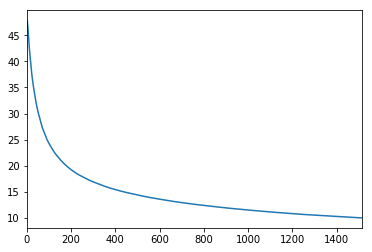

In [54]:
train_state_df = pd.DataFrame(train_state)
train_state_df['loss'].plot()
plt.show()

Learning rate values

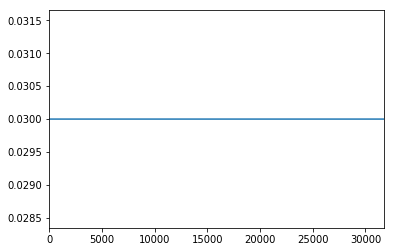

In [105]:
train_state_df['learning_rate'].plot()
plt.show()

Get matrices with word vectors, calculate average matrix, and save all theses matrices to file  
(Commented because it was used right after training)

In [55]:
W = classifier.emb_c.weight.detach().cpu().numpy()
W_prime = classifier.emb_o.weight.detach().cpu().numpy()

W_avg = (W + W_prime) / 2
np.savez(args.weights_path, W=W, W_prime=W_prime, W_avg=W_avg)

Preparing words for visualizing and intrinsic evaluation (word analogies and closest vectors)

In [56]:
words = []
words.extend(['man', 'he', 'woman', 'she'])
words.extend(['fly', 'plane', 'aircraft', 'sail', 'ship', 'ships', 'circle'])
words.extend(['kitten', 'cat', 'puppy', 'dog'])
words.extend(['leg', 'legs', 'hand', 'hands'])
words.extend(['blue', 'color', 'dog', 'breed'])
words.extend(['toe', 'finger', 'foot', 'hand', 'arm'])
words.extend(['talk', 'communicate', 'read', 'interpret'])
words.extend(['man', 'king', 'woman', 'queen', 'doctor'])
words.extend(['man', 'doctor', 'woman', 'nurse'])
words.extend(['fast', 'fastest', 'small', 'smallest', 'rich', 'richest', 'faster', 'stronger'])
words = list(set(words))

### Visualizing word vectors

Load saved weights for exploring final word vectors

In [11]:
weights = np.load('./models_final/task_3_window/weights.npz')
W = weights['W']
W_prime = weights['W_prime']

W_avg = weights['W_avg']

In [12]:
metadata = list(sg_batcher.token_to_idx)

writer = SummaryWriter(log_dir='logs_final/task_3_window', comment='embedding_training')
writer.add_embedding(W_avg, metadata=metadata, tag='W_avg')

We can now visualize words cloud in TensorBoard using PCA or TSNE

In [16]:
# <img src="images/task_3/1.PNG" style="height:480px width:640px">

In [17]:
# <img src="images/task_3/2.PNG" style="height:480px width:640px">

In [18]:
# <img src="images/task_3/3.PNG" style="height:480px width:640px">

In [19]:
# <img src="images/task_3/4.PNG" style="height:480px width:640px">

In [20]:
# <img src="images/task_3/5.PNG" style="height:480px width:640px">

**Conclusion**
- After exploring words, it seems that word cloud on the left side (picture 1) contains not popular words, and its neighbors don't have meaningful neigbors, whereas words in the right cloud are more frequent and have meaningful neighbors (pictures 2-5)

Let's check values in all 3 matrices using heatmaps

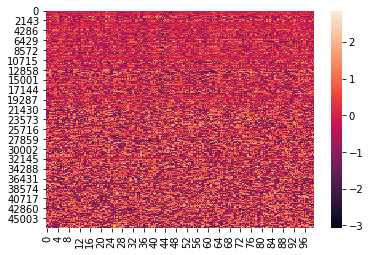

In [57]:
sns.heatmap(W)
plt.show()

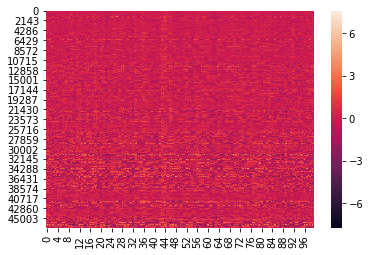

In [58]:
sns.heatmap(W_prime)
plt.show()

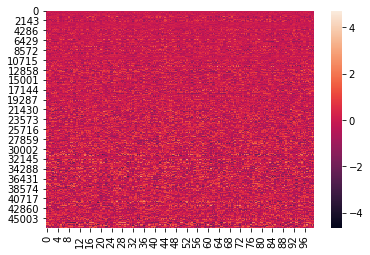

In [59]:
sns.heatmap(W_avg)

In [60]:
def plot_embeddings(embs_reduced, token_to_idx, tokens, fig_size=(12, 12)):
    token_embs = embs_reduced[[token_to_idx[token] for token in tokens]]
    
    fig, ax = plt.subplots(figsize=fig_size)
    ax.scatter(token_embs[:, 0], token_embs[:, 1], alpha=0.3)
    
    texts = [plt.text(token_embs[i, 0], token_embs[i, 1], f'{token}') for i, token in enumerate(tokens)]
    adjust_text(texts)

Apply PCA and visualize results

In [63]:
%%time
pca = PCA(n_components=2, random_state=42)
embs_pca = pca.fit_transform(W_avg)

CPU times: user 328 ms, sys: 12 ms, total: 340 ms
Wall time: 86.6 ms


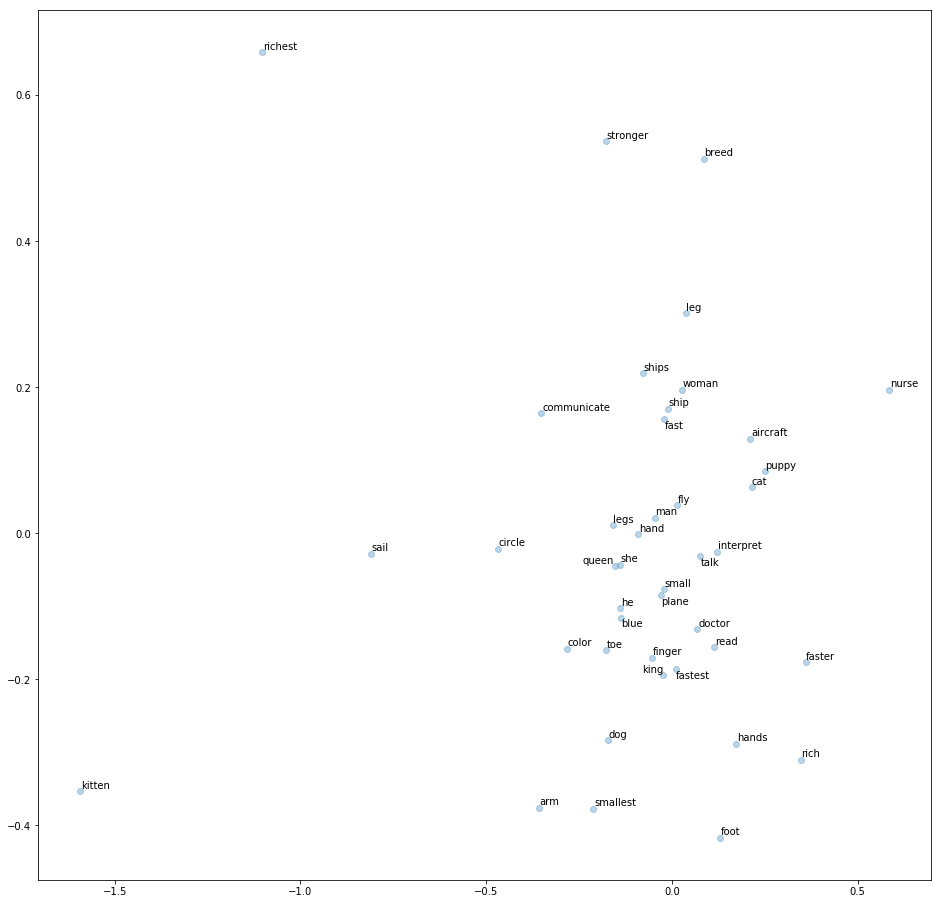

In [64]:
plot_embeddings(embs_pca, sg_batcher.token_to_idx, words, fig_size=(16, 16))

In [132]:
%%time
tsne = TSNE(n_components=2, n_iter=1000, n_jobs=-1)
embs_tsne = tsne.fit_transform(W_avg)

CPU times: user 24min 2s, sys: 9min 14s, total: 33min 17s
Wall time: 4min 17s


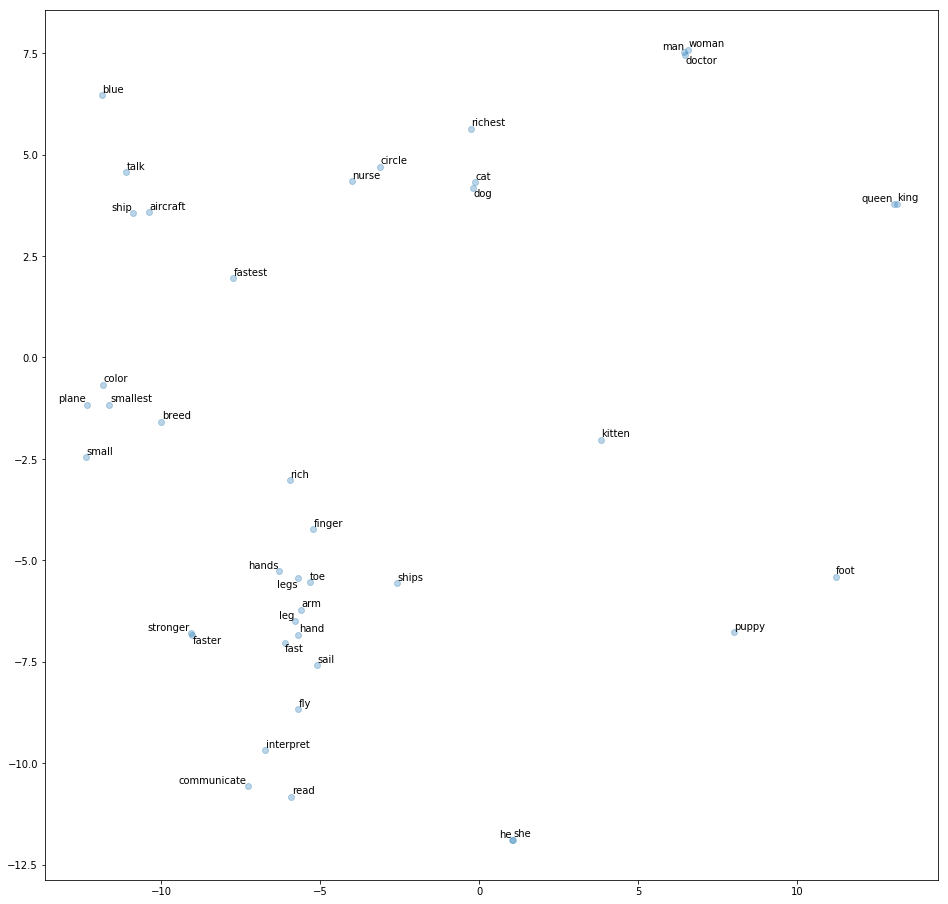

In [133]:
plot_embeddings(embs_tsne, sg_batcher.token_to_idx, words, fig_size=(16, 16))

In [28]:
class EmbeddingsExplorer():
    def __init__(self, token_to_idx, vectors, metric='euclidean'):
        self.token_to_idx = token_to_idx
        self.idx_to_token = {idx: token for token, idx 
                             in self.token_to_idx.items()}
        self.vectors = vectors
        self.metric = metric
        
        self.index = AnnoyIndex(vectors.shape[1], metric=metric)
        
        print('Building index is started')
        for i in self.token_to_idx.values():
            self.index.add_item(i, self.vectors[i])
        
        self.index.build(50)
        print('Building index is finished')
        
    def get_embedding(self, token):
        return self.vectors[self.token_to_idx[token]]
    
    def get_closest_to_vector(self, vector, n=1):
        nn_indices = self.index.get_nns_by_vector(vector, n)
        return [self.idx_to_token[neighbor] for neighbor in nn_indices]
    
    def compute_closest_tokens(self, target_token, n=1):
        vector = self.get_embedding(target_token)
        closest_tokens = self.get_closest_to_vector(vector, n=n)
        closest_tokens = [token for token in closest_tokens
                          if token != target_token]
        print(f'{target_token}: {closest_tokens}')
    
    def compute_analogy(self, token1, token2, token3, n=30):
        vec1 = self.get_embedding(token1)
        vec2 = self.get_embedding(token2)
        vec3 = self.get_embedding(token3)
        vec4 = vec3 + vec2 - vec1
        
        tokens = set([token1, token2, token3])
        closest_tokens = self.get_closest_to_vector(vec4, n=n)
        closest_tokens = [token for token in closest_tokens
                          if token not in tokens]
        
        if len(closest_tokens) == 0:
            print('Could not find nearest neighbors for the computed vector')
            return
        
        print(f'{token1}:{token2} :: {token3}:{closest_tokens}')

For evaluation, euclidean metric was used on trained average word vectors ((W + W_prime) / 2), without L2-normalization after training.   
With L2-normalization for each word vector, euclidean distance will be equal to cosine distance (because "Cosine distance is equivalent to Euclidean distance of normalized vectors", https://github.com/spotify/annoy), but it seems that normalization for each word vector or dimension break several syntactic or semantic analogies (maybe onlye for chosed words for evaluation, need more time for detailed exploration).  
I suppose that norm of the vectors is important feature for this task (more details can be found here - https://stats.stackexchange.com/questions/177905/should-i-normalize-word2vecs-word-vectors-before-using-them)  
Also different metrics were tested from Annoy package, but euclidean distance was chosen as subjectively the best metric for this specific evaluation.

In [29]:
emb_explorer = EmbeddingsExplorer(sg_batcher.token_to_idx, W_avg, metric='euclidean')
emb_explorer

Building index is started
Building index is finished


**Word Analogies**

This analogy is correct, word vectors capture gender difference ("she")

In [30]:
emb_explorer.compute_analogy('man', 'he', 'woman')

man:he :: woman:['she', 'was', 'eventually', 'subsequently', 'who', 'originally', 'it', 'had', 'held', 'later', 'when', 'did', 'married', 'released', 'discovered', 'met', 'which', 'named', 'played', 'finally', 'created', 'wrote', 'opened', 'announced', 'never', 'declared', 'actually', 'felt', 'would']


This analogy is wrong (something like "ship" was expected). It seems that word vector captures the meaning of the "plane" from math, so we can see words like "circle", "rotation", "column" etc.

In [31]:
emb_explorer.compute_analogy('fly', 'plane', 'sail')

fly:plane :: sail:['components', 'marrying', 'humanity', 'compact', 'all', 'sets', 'brain', 'definition', 'materials', 'fields', 'point', 'matter', 'these', 'result', 'instead', 'alloys', 'grounds', 'kinds', 'memes', 'material', 'compositions', 'mention', 'doors', 'proponents', 'unique', 'worship', 'facts', 'classes', 'practice']


If we change the word "plane" to "aircraft" - correct analogy will be captured ("submarine", "ships"), but there are also many words with military-related meaning

In [32]:
emb_explorer.compute_analogy('fly', 'aircraft', 'sail')

fly:aircraft :: sail:['materials', 'elements', 'opinion', 'components', 'individuals', 'fields', 'clashes', 'descriptions', 'humanity', 'regions', 'proponents', 'point', 'comparison', 'or', 'words', 'vapor', 'limit', 'needs', 'conditions', 'marrying', 'attributes', 'results', 'concentrations', 'cells', 'moves', 'bear', 'christians', 'arises', 'those']


This analogy was captured correctly (expected "dog")

In [33]:
emb_explorer.compute_analogy('kitten', 'cat', 'puppy')

kitten:cat :: puppy:['minutes', 'nm', 'poles', 'months', 'lipids', 'pngimage', 'misdemeanors', 'seats', 'kilometers', 'four', 'acquainted', 'thirds', 'three', 'orbiting', 'equipped', 'hydro', 'palma', 'convened', 'inch', 'years', 'bytes', 'falcons', 'disproved', 'kilobytes', 'shoulder', 'two', 'antoni', 'firmly', 'olympia']


But it seems that reverse analogy was not captured (expected something like "puppy")

In [34]:
emb_explorer.compute_analogy('cat', 'kitten', 'dog')

cat:kitten :: dog:['lamenting', 'libertine', 'somali', 'electronically', 'vizier', 'bengals', 'bocce', 'macros', 'orthographic', 'crank', 'kazakh', 'harmonize', 'alkene', 'outweigh', 'brandon', 'misty', 'uribe', 'halmos', 'noses', 'favoring', 'lena', 'rollins', 'empiricism', 'coronary', 'endeavour', 'nba', 'founds', 'aung', 'glance']


Analogy from specific to common is captured correctly (expected something like "breed")

In [35]:
emb_explorer.compute_analogy('blue', 'color', 'dog')

blue:color :: dog:['wind', 'extending', 'deuterium', 'blade', 'canon', 'spaniards', 'documentary', 'essence', 'involving', 'from', 'within', 'allowing', 'organic', 'entails', 'polar', 'audience', 'node', 'lightning', 'causing', 'ilo', 'mirror', 'restrictions', 'equipment', 'client', 'straight', 'beans', 'attention', 'detail']


Analogy from part to the whole is almost captured correctly (expected something like "hand", but "arm" is captured)

In [36]:
emb_explorer.compute_analogy('toe', 'finger', 'foot')

toe:finger :: foot:['photography', 'dartmouth', 'mara', 'eritrea', 'professor', 'darius', 'classification', 'romania', 'personnel', 'images', 'shops', 'youth', 'members', 'counties', 'se', 'brazil', 'galileo', 'marriages', 'pact', 'homeomorphism', 'arcade', 'interval', 'daughter', 'expedition', 'battles', 'ninth', 'enabling', 'males']


Word analogy for the process is also has meaningful result (expected something like "interpret")

In [37]:
emb_explorer.compute_analogy('talk', 'communicate', 'read')

talk:communicate :: read:['considered', 'merely', 'not', 'produce', 'nothing', 'otherwise', 'necessary', 'still', 'simply', 'accept', 'get', 'quite', 'too', 'would', 'hold', 'find', 'usually', 'willing', 'require', 'impossible', 'used', 'necessarily', 'shown', 'assigned', 'required', 'clear', 'unable', 'should']


Classic word analogy is also captured but not in top-1 (expected "queen"), many words which are related to roalty are also captured royalty

In [123]:
emb_explorer.compute_analogy('man', 'king', 'woman')

man:king :: woman:['philip', 'alexander', 'henry', 'elizabeth', 'samuel', 'prince', 'cicero', 'francis', 'tsar', 'joseph', 'gerard', 'edward', 'ivan', 'parker', 'isabella', 'jean', 'empress', 'alfonso', 'tudor', 'jacob', 'john', 'holt', 'josiah', 'charles', 'arthur', 'gustav', 'hassan', 'rector', 'hamid']


Stereotypes with gender and job titles are also captured
- 1st analogy: "nurse" is top-1 word
- 2nd analogy: "detective" is in top-5 words

In [124]:
emb_explorer.compute_analogy('man', 'doctor', 'woman')

man:doctor :: woman:['girl', 'soldier', 'martyr', 'monarch', 'hero', 'warrior', 'goethe', 'archer', 'thompson', 'pseudonym', 'wheeler', 'dan', 'wills', 'salinger', 'nin', 'reich', 'filmmaker', 'priest', 'publisher', 'marc', 'romano', 'wade', 'novella', 'parisian', 'spy', 'linguist', 'mcmahon', 'lawyer']


In [125]:
emb_explorer.compute_analogy('woman', 'doctor', 'man')

woman:doctor :: man:['dog', 'witch', 'declension', 'goddess', 'stone', 'wisdom', 'arc', 'grace', 'beast', 'parody', 'tale', 'creature', 'master', 'humour', 'dream', 'repentance', 'monster', 'creator', 'adventures', 'cheers', 'nickname', 'performer', 'cat', 'bullet', 'crimson', 'evil', 'blockbuster', 'dove']


Directions analogy is also captured (expected 'top')

In [126]:
# right:left :: bottom:top
emb_explorer.compute_analogy('right', 'left', 'bottom')

right:left :: bottom:['belt', 'underworld', 'marble', 'sunrise', 'iliad', 'stone', 'crest', 'casing', 'steep', 'nearby', 'snow', 'shrine', 'beside', 'wizards', 'merger', 'rising', 'clay', 'front', 'venus', 'palm', 'beginning', 'crossing', 'renaming', 'mantle', 'circle', 'prairie', 'wall', 'rolling', 'connecting']


Word vectors also capture syntaсtic analogies
- 1st analogy: expected "hands", captured
- 2nd analogy: expected "smallest", not captured, but there are antonyms of in top ("large", "vast", "huge", "substantial")
- 3rd analogy: expected "oldest", captured
- 4th analogy: expected "stronger", captured

In [127]:
emb_explorer.compute_analogy('leg', 'legs', 'finger')

leg:legs :: finger:['swords', 'casing', 'suits', 'vehicles', 'holes', 'helicopters', 'tracks', 'daughters', 'coins', 'minted', 'vessels', 'climbers', 'dozens', 'drawings', 'flags', 'tanks', 'records', 'tides', 'ropes', 'pitches', 'upstream', 'hence', 'photographers', 'colours', 'countless', 'participants', 'encouraging', 'marks']


In [128]:
emb_explorer.compute_analogy('fast', 'fastest', 'small')

fast:fastest :: small:['large', 'larger', 'huge', 'vast', 'smaller', 'scale', 'suburban', 'margin', 'proportion', 'frozen', 'dispersion', 'wooden', 'forming', 'decline', 'tide', 'peak', 'portion', 'whole', 'massive', 'growing', 'waterway', 'forest', 'staircase', 'granite', 'depths', 'dome', 'towns', 'slight', 'boundaries']


In [129]:
emb_explorer.compute_analogy('large', 'largest', 'old')

large:largest :: old:['aztec', 'eighth', 'anglo', 'ninth', 'assyrian', 'seventh', 'imperial', 'entire', 'athenian', 'irish', 'sino', 'inquisition', 'basque', 'boer', 'egyptian', 'dominican', 'seventeenth', 'turkish', 'armenian', 'sikh', 'babylonian', 'poorest', 'achaemenid', 'bolshevik', 'chechen', 'frankish', 'episcopal', 'latvian', 'cathedral']


In [130]:
emb_explorer.compute_analogy('fast', 'faster', 'strong')

fast:faster :: strong:['stronger', 'slight', 'heavier', 'more', 'severe', 'economical', 'deeper', 'devastating', 'consistent', 'powerful', 'intense', 'aggressive', 'simpler', 'comfortable', 'rather', 'stable', 'risky', 'realistic', 'complicated', 'tremendous', 'moderate', 'productive', 'explicit', 'coherent', 'intimate', 'fewer', 'less', 'weaker']


**Top closest words**

In [131]:
for word in words:
    emb_explorer.compute_closest_tokens(word, n=10)

breed: ['phrase', 'believer', 'tune', 'mention', 'spell', 'negation', 'medication', 'another', 'freeway']
she: ['he', 'nobody', 'reportedly', 'hoped', 'supposedly', 'ruth', 'instructed', 'gehrig', 'afterwards']
talk: ['abc', 'host', 'math', 'forums', 'efnet', 'cbs', 'network', 'channels', 'relay']
read: ['delivered', 'write', 'myself', 'anybody', 'looked', 'proceed', 'kill', 'send', 'get']
interpret: ['discuss', 'enable', 'obey', 'explore', 'discover', 'describe', 'oppose', 'celebrate', 'preserve']
plane: ['runway', 'bow', 'pitch', 'bullet', 'stick', 'closed', 'counting', 'rope', 'spot']
color: ['colour', 'pattern', 'sound', 'datagram', 'frame', 'cpu', 'frequency', 'colors', 'wavelength']
aircraft: ['carriers', 'combat', 'carrier', 'reconnaissance', 'avionics', 'personnel', 'airborne', 'bases', 'vehicle']
fly: ['move', 'onto', 'pass', 'confer', 'clean', 'wash', 'draw', 'handle', 'through']
man: ['straw', 'sword', 'woman', 'child', 'creature', 'batter', 'mistake', 'terrible', 'bride']
r

In [60]:
arr

(tensor([0, 1, 1]), tensor([1, 0, 2]))

In [61]:
clf = NaiveWord2VecClassifier(sg_batcher.vocab_size, 2, token_neg_probs)
res = clf(arr[0], arr[1])
res

(tensor([[[ 1.1797,  0.4361]],
 
         [[-0.7912,  2.7042]],
 
         [[-0.7912,  2.7042]]], grad_fn=<UnsqueezeBackward0>),
 tensor([[[-0.1261, -0.3783]],
 
         [[-0.7053, -2.3925]],
 
         [[-2.1433,  0.5064]]], grad_fn=<UnsqueezeBackward0>),
 tensor([[[ 1.2732,  0.0964],
          [-0.4310,  0.2485],
          [ 1.6246,  1.3157]],
 
         [[ 0.5245,  1.5212],
          [-0.6701,  0.4132],
          [ 0.1806,  0.1006]],
 
         [[-0.8705, -0.6348],
          [-0.7773,  2.0352],
          [-0.2422, -0.9725]]], grad_fn=<EmbeddingBackward>),
 tensor([[[-0.1261, -0.3783],
          [ 1.2732,  0.0964],
          [-0.4310,  0.2485],
          [ 1.6246,  1.3157]],
 
         [[-0.7053, -2.3925],
          [ 0.5245,  1.5212],
          [-0.6701,  0.4132],
          [ 0.1806,  0.1006]],
 
         [[-2.1433,  0.5064],
          [-0.8705, -0.6348],
          [-0.7773,  2.0352],
          [-0.2422, -0.9725]]], grad_fn=<CatBackward>),
 tensor([[[-0.3137,  1.5439, -0.4001,  2.4

In [31]:
v_c, v_o, neg = res
v_c.shape, v_o.shape, neg.shape

(torch.Size([3, 1, 2]), torch.Size([3, 1, 2]), torch.Size([3, 3, 2]))

In [42]:
out = torch.cat([v_o, neg], dim=1)
out, out.shape

(tensor([[[-0.2888,  0.6249],
          [ 1.1585,  0.5260],
          [-1.6186,  0.1671],
          [-0.0336,  1.5858]],
 
         [[-0.9628, -1.4028],
          [ 0.4094, -0.1571],
          [-0.5948, -0.5606],
          [-0.7173, -0.4253]],
 
         [[-0.6701, -1.8614],
          [-0.7509,  0.4703],
          [-1.6277,  0.5216],
          [ 0.5919, -1.1879]]], grad_fn=<CatBackward>), torch.Size([3, 4, 2]))

In [47]:
torch.transpose(out, 1, 2), torch.transpose(out, 1, 2).shape

(tensor([[[-0.2888,  1.1585, -1.6186, -0.0336],
          [ 0.6249,  0.5260,  0.1671,  1.5858]],
 
         [[-0.9628,  0.4094, -0.5948, -0.7173],
          [-1.4028, -0.1571, -0.5606, -0.4253]],
 
         [[-0.6701, -0.7509, -1.6277,  0.5919],
          [-1.8614,  0.4703,  0.5216, -1.1879]]], grad_fn=<TransposeBackward0>),
 torch.Size([3, 2, 4]))

In [49]:
y_out = torch.bmm(v_c, torch.transpose(out, 1, 2))
y_out, y_out.shape

(tensor([[[ 1.9716, -0.4364,  2.8321,  3.9576]],
 
         [[-0.6236, -0.3104, -0.1515,  0.0089]],
 
         [[-1.1099,  0.7084,  1.1554, -1.1825]]], grad_fn=<BmmBackward>),
 torch.Size([3, 1, 4]))

In [54]:
-F.logsigmoid(y_out[:, :, 0]), -F.logsigmoid(-y_out[:, :, 1:])

(tensor([[0.1304],
         [1.0528],
         [1.3948]], grad_fn=<NegBackward>), tensor([[[0.4986, 2.8894, 3.9765]],
 
         [[0.5499, 0.6203, 0.6976]],
 
         [[1.1088, 1.4292, 0.2674]]], grad_fn=<NegBackward>))

In [70]:
loss = -torch.sum(F.logsigmoid(y_out[:, :, 0])) - torch.sum(F.logsigmoid(-y_out[:, :, 1:]))
loss.item()

14.615554809570312

In [63]:
g = sg_batcher.generate_batches(window_size=3,
                                batch_size=1024)

In [42]:
for _ in tqdm_notebook(range(100)):
    np.random.choice(range(sg_batcher.vocab_size),
                        size = 1024 * 3,
                        replace=True,
                        p = sg_batcher.token_neg_probs).reshape(1024, -1)

In [47]:
for _ in tqdm_notebook(range(100)):
    sg_batcher._generate_negative_outputs(k=3, size=256)

In [26]:
np.random.choice(range(len(sg_batcher.vocab)), size=12, replace=True, p=sg_batcher.token_neg_probs).reshape(3, -1)

array([[ 1639, 10077,  6125,  2075],
       [ 3150,  4959, 29402,   305],
       [ 1563, 12646, 38240, 25660]])

In [213]:
batch = [(0, (1, [340, 34997, 15])), (0, (2, [248, 11726, 1903])), (0, (3, [13380, 45263, 4490]))]
batch

[(0, (1, [340, 34997, 15])),
 (0, (2, [248, 11726, 1903])),
 (0, (3, [13380, 45263, 4490]))]

In [216]:
list(zip(*batch))[1]

((1, [340, 34997, 15]), (2, [248, 11726, 1903]), (3, [13380, 45263, 4490]))

In [142]:
center = [0, 0, 0]
context = [[(0, (1, [23790, 4499, 165])),
          (0, (2, [4135, 20707, 13853])),
          (0, (3, [4306, 3837, 243]))]]

In [144]:
list(zip(center, context))

[(0, (1, [14550, 17844, 19042])),
 (0, (2, [5141, 33485, 21678])),
 (0, (3, [3263, 675, 33346]))]

In [168]:
batch = [(0, (1, [4508, 267, 1695])), (0, (2, [4084, 344, 27567])), (0, (3, [6347, 327, 10095]))]
batch

[(0, (1, [4508, 267, 1695])),
 (0, (2, [4084, 344, 27567])),
 (0, (3, [6347, 327, 10095]))]

In [170]:
list(zip(batch))

TypeError: list() takes at most 1 argument (3 given)

In [ ]:
sg_batcher.token_neg_probs[:3]

In [ ]:
neg_g = sg_batcher._get_negative_outputs(k=3, size=3)
neg_g

In [117]:
list(chain.from_iterable(zip([1, 2, 3], neg_g)))

[1, [1801, 579, 25424], 2, [4366, 32120, 381], 3, [8384, 21399, 5617]]

In [98]:
t = torch.multinomial(torch.tensor(token_neg_probs), 
                        12, replacement=False).view(3, -1)
t

tensor([[  506, 20011,  2034,   823],
        [14741, 20081, 18746, 41748],
        [24784,    15, 26064,  4076]])

In [105]:
t.numpy().tolist()

[[506, 20011, 2034, 823],
 [14741, 20081, 18746, 41748],
 [24784, 15, 26064, 4076]]

In [109]:
args = Namespace(
    file_path = DATA_PATH/'text8',
    model_state_path = MODELS_PATH/'naive_word2vec_embeddings.pth',
    weights_path = MODELS_PATH/'weights.npz',
    
    embedding_size = 100,
    
    seed = 42,
    cutoff = 10,
    window_size = 3,
    stride = 1,
    batch_size = 1024,
    learning_rate = 0.03,
    iterations = 1000,
    save_iterations = 100,
    early_stopping_criteria = 1e8,
    factor=0.5,
    patience=5000,
    neg_prob_degree=0.75
    
    cuda=True
)

In [284]:
g = sg_batcher._create_sliding_window(2)
next(g)

[[(0, 1), (0, 2)]]

In [36]:
tokens_size = len(sg_batcher.tokens)
tokens_size

16561031

In [77]:
token_neg_scores = np.array([(value/sg_batcher.tokens_size)**0.75
                            for key, value in sg_batcher.token_counts.items()])
token_neg_scores[:10]

array([0.00027975, 0.00045054, 0.0266476 , 0.05253766, 0.00301677,
       0.08238481, 0.00044521, 0.00851808, 0.00713238, 0.00338947])

In [38]:
token_neg_scores_sum = np.sum(token_neg_scores)
token_neg_scores_sum

8.252735343222646

In [39]:
token_neg_probs = token_neg_scores / token_neg_scores_sum
token_neg_probs

array([3.38975668e-05, 5.45925746e-05, 3.22894152e-03, ...,
       2.62474160e-06, 3.90771827e-06, 2.62474160e-06])

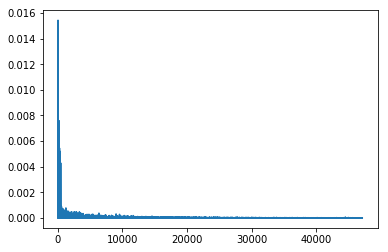

In [94]:
plt.plot(token_neg_probs)

In [316]:
k = 5
batch_size = 3
arr = token_neg_probs # [1, 5, 6, 10]

x_numpy = np.array(arr) / np.sum(arr)
x_torch = torch.tensor(x_numpy, dtype=torch.float32)
x_torch, x_numpy

(tensor([3.3898e-05, 5.4593e-05, 3.2289e-03,  ..., 2.6247e-06, 3.9077e-06,
         2.6247e-06]),
 array([3.38975668e-05, 5.45925746e-05, 3.22894152e-03, ...,
        2.62474160e-06, 3.90771827e-06, 2.62474160e-06]))

In [317]:
sample_torch = torch.multinomial(x_torch, k, replacement=True) #.view(batch_size, -1)
print(np.bincount(sample_torch) / np.bincount(sample_torch).sum())
sample_torch

[0.  0.  0.  ... 0.  0.  0.2]


tensor([   15, 25967,  1177,  5236, 23144])

In [273]:
sample_numpy = np.random.multinomial(1, x_numpy, size=k).nonzero()[1]
print(np.bincount(sample_numpy) / np.bincount(sample_numpy).sum())
sample_numpy

[0.  0.  0.2 0.8]


array([2, 3, 3, 3, 3])